In [30]:
from PIL import Image
import os, glob, sys, numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

img_dir = './data3/train'
categories = ['0', '1']
np_classes = len(categories)

image_w = 128
image_h = 128


pixel = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    img_dir_detail = img_dir + "/" + cat
    files = glob.glob(img_dir_detail+"/*.jpg")


    for i, f in enumerate(files):
        try:
            img = Image.open(f)
            img = img.convert("RGB")
            img = img.resize((image_w, image_h))
            data = np.asarray(img)
            #Y는 0 아니면 1이니까 idx값으로 넣는다.
            X.append(data)
            y.append(idx)
            if i % 300 == 0:
                print(cat, " : ", f)
        except:
            print(cat, str(i)+" 번째에서 에러 ")
X = np.array(X)
Y = np.array(y)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

xy = (X_train, X_test, Y_train, Y_test)
np.save("./image_data.npy", xy)

0  :  ./data3/train/0\Tomato_healthy (1).JPG
0  :  ./data3/train/0\Tomato_healthy (1269).JPG
0  :  ./data3/train/0\Tomato_healthy (1539).JPG
0  :  ./data3/train/0\Tomato_healthy (377).JPG
0  :  ./data3/train/0\Tomato_healthy (647).JPG
0  :  ./data3/train/0\Tomato_healthy (917).JPG
1  :  ./data3/train/1\Tomato_Septoria (1).JPG
1  :  ./data3/train/1\Tomato_Septoria (397).JPG
1  :  ./data3/train/1\Tomato_Septoria (667).JPG
1  :  ./data3/train/1\Tomato_Septoria (937).JPG
1  :  ./data3/train/1\Tomato_Spider (1206).JPG
1  :  ./data3/train/1\Tomato_Spider (1477).JPG
1  :  ./data3/train/1\Tomato_Spider (1747).JPG
1  :  ./data3/train/1\Tomato_Spider (2016).JPG
1  :  ./data3/train/1\Tomato_Spider (2287).JPG
1  :  ./data3/train/1\Tomato_Spider (2557).JPG


C:\Users\Administrator\anaconda3\envs\keras\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow.python.keras.backend as K

X_train, X_test, y_train, y_test = np.load('./numpy_data/image_data.npy', allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])
print(X_train.shape[1:])
print(np.bincount(y_train))
print(np.bincount(y_test))

(3965, 128, 128, 3)
3965
[1443 2522]
[148 293]


In [13]:
image_w = 128
image_h = 128
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

import tensorflow.compat.v1 as tf

with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    model_path = model_dir + "/plant.model"
    
    checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=7)


In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 64)       

In [15]:
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.15, callbacks=[checkpoint, early_stopping])

Epoch 1/100
53/53 [==============================] - 61s 1s/step - loss: 0.6539 - accuracy: 0.6073 - val_loss: 0.4030 - val_accuracy: 0.7613

Epoch 00001: val_loss improved from inf to 0.40304, saving model to ./model\plant.model
INFO:tensorflow:Assets written to: ./model\plant.model\assets
Epoch 2/100
53/53 [==============================] - 55s 1s/step - loss: 0.3777 - accuracy: 0.8269 - val_loss: 0.2150 - val_accuracy: 0.9176

Epoch 00002: val_loss improved from 0.40304 to 0.21496, saving model to ./model\plant.model
INFO:tensorflow:Assets written to: ./model\plant.model\assets
Epoch 3/100
53/53 [==============================] - 52s 987ms/step - loss: 0.1804 - accuracy: 0.9275 - val_loss: 0.0842 - val_accuracy: 0.9748

Epoch 00003: val_loss improved from 0.21496 to 0.08418, saving model to ./model\plant.model
INFO:tensorflow:Assets written to: ./model\plant.model\assets
Epoch 4/100
53/53 [==============================] - 55s 1s/step - loss: 0.1026 - accuracy: 0.9625 - val_loss: 0.

In [24]:
print("정확도 : %.2f " %(model.evaluate(X_test, y_test)[1]))

14/14 [==============================] - 2s 111ms/step - loss: 0.0019 - accuracy: 1.0000
정확도 : 1.00 


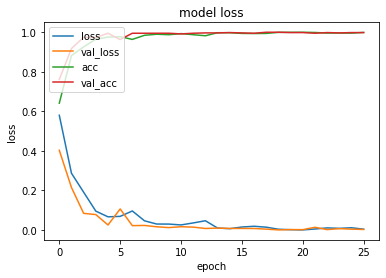

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'acc', 'val_acc'], loc='upper left')
plt.show()

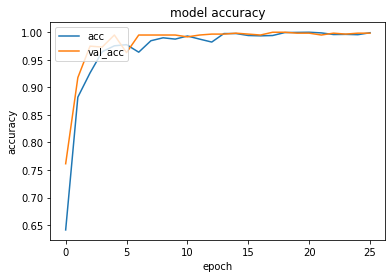

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

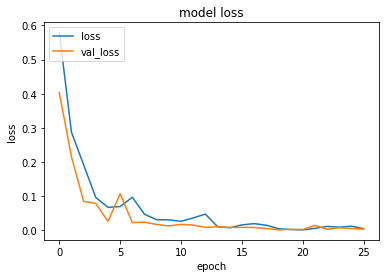

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [29]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

import tensorflow.compat.v1 as tf

seed = 5
tf.set_random_seed(seed)
np.random.seed(seed)

caltech_dir = './data3/test'


image_w = 128
image_h = 128

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*/*.*")

for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)

    filenames.append(f)
    X.append(data)


X = np.array(X)
X = X.astype(float) / 255
model = load_model('./model/plant.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0
for i in prediction:
    if i >= 0.5: print(filenames[cnt].split("\\")[1] + filenames[cnt].split("\\")[2] + " 이미지는 식물병입니다.")
    else : print(filenames[cnt].split("\\")[1] + filenames[cnt].split("\\")[2] + " 이미지는 정상입니다.")
    cnt += 1

0Tomato_healthy (43).JPG 이미지는 정상입니다.
0Tomato_healthy (44).JPG 이미지는 정상입니다.
0Tomato_healthy (45).JPG 이미지는 정상입니다.
0Tomato_healthy (46).JPG 이미지는 정상입니다.
0Tomato_healthy (47).JPG 이미지는 정상입니다.
0Tomato_healthy (48).JPG 이미지는 정상입니다.
0Tomato_healthy (49).JPG 이미지는 정상입니다.
0Tomato_healthy (50).JPG 이미지는 정상입니다.
0Tomato_healthy (51).JPG 이미지는 정상입니다.
0Tomato_healthy (52).JPG 이미지는 정상입니다.
0Tomato_healthy (68).JPG 이미지는 정상입니다.
0Tomato_healthy (69).JPG 이미지는 정상입니다.
0Tomato_healthy (70).JPG 이미지는 정상입니다.
0Tomato_healthy (71).JPG 이미지는 정상입니다.
0Tomato_healthy (72).JPG 이미지는 정상입니다.
1CornCommonRust1.JPG 이미지는 정상입니다.
1CornCommonRust2.JPG 이미지는 정상입니다.
1CornCommonRust3.JPG 이미지는 식물병입니다.
1PotatoEarlyBlight1.JPG 이미지는 정상입니다.
1PotatoEarlyBlight2.JPG 이미지는 정상입니다.
1PotatoEarlyBlight3.JPG 이미지는 식물병입니다.
1PotatoEarlyBlight4.JPG 이미지는 식물병입니다.
1PotatoEarlyBlight5.JPG 이미지는 정상입니다.
1TomatoEarlyBlight2.JPG 이미지는 식물병입니다.
1TomatoEarlyBlight3.JPG 이미지는 식물병입니다.
